In [ ]:
#KSS ticker  Kohl's

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.preprocessing import MinMaxScaler

from yahoo_fin.stock_info import get_data

In [ ]:
#interval: {“1d”, “1wk”, “1mo”}. Refers to the interval to sample the data: “1d”= daily, “1wk”= weekly, “1mo”=monthly.

In [3]:
api_df= get_data("kss", start_date="12/04/2010", end_date="07/04/2022", index_as_date = False, interval="1d")
api_df

,date,open,high,low,close,adjclose,volume,ticker
0,2010-12-06,55.419998,55.419998,54.759998,55.000000,37.186840,3246600,KSS
1,2010-12-07,55.509998,55.939999,54.349998,54.580002,36.902870,6608100,KSS
2,2010-12-08,54.560001,54.830002,53.369999,54.410000,36.787926,7148400,KSS
3,2010-12-09,54.709999,54.770000,53.700001,54.220001,36.659466,3498700,KSS
4,2010-12-10,54.130001,54.610001,53.470001,53.639999,36.267315,5588600,KSS
...,...,...,...,...,...,...,...,...
2908,2022-06-27,39.049999,39.049999,37.549999,37.680000,37.680000,6231900,KSS
2909,2022-06-28,37.910000,38.549999,36.560001,36.820000,36.820000,3485700,KSS
2910,2022-06-29,36.570000,37.000000,35.720001,35.910000,35.910000,2967100,KSS
2911,2022-06-30,35.169998,35.730000,34.330002,35.689999,35.689999,3341000,KSS


In [4]:
#print the summary 
print(api_df.describe())

              open         high          low        close     adjclose  \
count  2913.000000  2913.000000  2913.000000  2913.000000  2913.000000   
mean     50.885191    51.621912    50.164422    50.880034    41.307367   
std      12.126089    12.201524    12.050913    12.133268    11.119459   
min      11.750000    11.990000    10.890000    11.510000    11.067064   
25%      45.169998    45.750000    44.410000    45.080002    34.432392   
50%      51.139999    51.790001    50.610001    51.150002    38.418545   
75%      56.869999    57.619999    56.090000    56.880001    48.152790   
max      82.440002    83.279999    81.239998    82.050003    71.570518   

             volume  
count  2.913000e+03  
mean   4.134623e+06  
std    3.151910e+06  
min    7.747000e+05  
25%    2.499100e+06  
50%    3.280800e+06  
75%    4.548800e+06  
max    4.507500e+07  


In [9]:
#prep the data 
api_df.set_index(pd.DatetimeIndex(api_df['date']), inplace=True)

In [12]:
#Keep the close for 2014-19
api_df = api_df[['close']]
api_df

,close
date,
2010-12-06,55.000000
2010-12-07,54.580002
2010-12-08,54.410000
2010-12-09,54.220001
2010-12-10,53.639999
...,...
2022-06-27,37.680000
2022-06-28,36.820000
2022-06-29,35.910000


In [13]:
print (api_df.index.max())

2022-07-01 00:00:00


In [15]:
data = api_df.filter(['close'])
dataset = data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

training_data_len =math.ceil(len(dataset) *.7)
train_data =scaled_data[0:training_data_len , : ]


X_train_data = []
y_train_data = []

for i in range(1500,len(train_data)):
    X_train_data=list(X_train_data)
    y_train_data=list(y_train_data)
    X_train_data.append(train_data[i-1500:i,0])
    y_train_data.append(train_data[i,0])
    
    X_train_data1, y_train_data1 = np.array(X_train_data), np.array(y_train_data)
    
    X_train_data2 = np.reshape(X_train_data1,(X_train_data1.shape[0],X_train_data1.shape[1],1))

   
    
#1500 = number of days you can change it accordingly. 

# There will be a total of 60 values, 1st column will contain an index of 0-59
# The second will have an index of 1-60 ++_
# the y_train has the 60 st value on c1 and c2 will have 61++

In [16]:
#Build the LSTM MODEL 

model = Sequential()

model.add(LSTM(units=50, return_sequences=True,input_shape=(X_train_data2.shape[1],1)))

model.add(LSTM(units=50, return_sequences=False))

model.add(Dense(units=25))

model.add(Dense(units=1))

In [17]:
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_data2, y_train_data1, batch_size=1, epochs=1)

540/540 [==============================] - 295s 539ms/step - loss: 0.0072


In [19]:
test_data = scaled_data[training_data_len -1500: , : ]

X_test = []

y_test = dataset[training_data_len : , : ]

for i in range(1500,len(test_data)):
    
    X_test.append(test_data[i-1500:i,0])

X_test = np.array(X_test)

X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)

28/28 [==============================] - 11s 343ms/step


In [20]:
# Error calculation where RMSE = root mean squared error 

rmse=np.sqrt(np.mean(((predictions-y_test)**2)))

In [21]:
print(rmse)

4.079298608696916


C:\Users\rctay\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


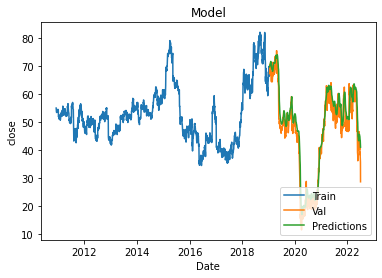

In [24]:
#Predict and visualize 

train = api_df[:training_data_len]

valid = api_df[training_data_len:]

valid['Predictions'] = predictions

plt.title('Model')

plt.xlabel('Date')

plt.ylabel('close')

plt.plot(train['close'])

plt.plot(valid[['close', 'Predictions']])

plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

plt.show()

<AxesSubplot:xlabel='date'>

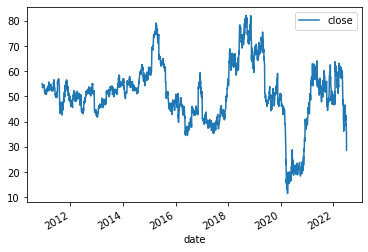

In [25]:
api_df.plot()